In [ ]:
!pip install tensorflow
!pip install tensorflow_io
!pip install kafka-python
!pip install datasets

In [2]:
from datasets import load_dataset

In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
nifty_data = load_dataset('Data/', split='train', streaming=True)
print(next(iter(nifty_data)))

{'Date ': '01-JAN-2019', 'Open ': 10881.7, 'High ': 10923.6, 'Low ': 10807.1, 'Close ': 10910.1, 'Shares Traded ': 159404542, 'Turnover (₹ Cr)': 8688.26}


In [5]:
def preprocessing(example: dict):
      date = pd.to_datetime(example.pop('Date '))
      example['High '] /= 10000
      example['Low '] /= 10000

      example['Shares Traded '] /= 200000000
      example['Turnover (₹ Cr)'] /= 10000
      example['Day'] = date.day
      example['Month'] = date.month
      example['Year'] = date.year - 2005
      open = example.pop('Open ')/10000
      close = example.pop('Close ')/10000
      return open, close, np.array(list(example.values()),dtype=float)


In [7]:
#Plotting
import matplotlib.pyplot as plt


In [8]:
import numpy as np

class SGD_Model():

  def __init__(self):

      # Initialize coefficients and bias
      self.coef = np.array([0.5,0.5,0,0,0,0,0])
      self.bias = 1


      self.no_of_datapoints = 0
      self.test_x = []
      self.test_y = []

  def predict(self, x,y):
      ypred = np.dot(x, self.coef) + self.bias
      return ypred

  def plot_test(self,title:str,ytitle:str,title2:str,ytitle2:str):
      ypred=[]
      for i in range(len(self.test_x)):
        ypred.append(np.dot(self.test_x[i], self.coef) + self.bias)

      plot_ypred = np.array(ypred)
      plot_y = np.array(self.test_y)


      plt.plot(range(len(self.test_x)),plot_ypred*10000,color = 'red')
      plt.plot(range(len(self.test_x)),plot_y*10000,color = 'blue')
      plt.title(title)
      plt.ylabel(ytitle)
      plt.savefig("fig/1.jpg")
      plt.close()

      plt.plot(range(len(self.test_x)),(plot_ypred-plot_y)*10000,color = 'red')
      plt.title(title2)
      plt.ylabel(ytitle)
      plt.savefig("fig/2.jpg")
      plt.close()

  def mean_squared_error(self):
      if (len(self.test_x) == 0):
        return 0
      squared_err = 0
      for i in range(len(self.test_x)):
        ypred = np.dot(self.test_x[i], self.coef) + self.bias
        squared_err += (self.test_y[i] - ypred) ** 2
      return squared_err/len(self.test_x)

  # Stochastic gradient descent for linear regression with streaming error calculation

  def update_sgd(self, x,y,learning_rate = np.exp(-8),epochs = 20):

      self.no_of_datapoints += 1
        #epochs = 1 + int(np.sqrt(100/self.no_of_datapoints))

      if self.no_of_datapoints % 5 != 0:

        for epoch in range(epochs):

          #SGD optimization loop
          y_pred = np.dot(x, self.coef) + self.bias

          # Compute gradients
          gradient_coef = -2 * x * (y - y_pred)
          gradient_bias = -2 * (y - y_pred)


          self.coef -= learning_rate * gradient_coef
          self.bias -= learning_rate * gradient_bias

          y_pred = np.dot(x, self.coef) + self.bias

      else:
        self.test_x.append(x)
        self.test_y.append(y)

      return self.coef, self.bias



In [ ]:

for step in range(5):
  epochs = step*10+10

  model1 = SGD_Model()
  for example in nifty_data:
    Y1,Y2, X = preprocessing(example)
    model1.update_sgd(x=X, y=Y1,epochs=epochs)
  model1.plot_test(f"Open Price with {str(epochs)} epochs",'Open Price',f"Error with {str(epochs)} epochs",'Error')
  print(f"No of epochs {epochs}, Mean Error: {model1.mean_squared_error()}")

No of epochs 10, Mean Error: 0.01943425021345963
No of epochs 20, Mean Error: 0.019526869035505337
No of epochs 30, Mean Error: 0.019550259589437798
No of epochs 40, Mean Error: 0.01955570501123976
No of epochs 50, Mean Error: 0.019556971416155054


In [9]:
def preprocessing_block(blocks_df):
    date = pd.to_datetime(blocks_df['Date '],format="%d-%b-%Y")
    blocks_df['High '] /= 10000
    blocks_df['Low '] /= 10000
    blocks_df['Shares Traded '] /= 200000000
    blocks_df['Turnover (₹ Cr)'] /= 10000
    blocks_df['Day'] = date.dt.day.values
    blocks_df['Month'] = date.dt.day.values
    blocks_df['Year'] = date.dt.year.values - 2005
    open_values = (blocks_df['Open ']/10000)
    close_values = (blocks_df['Close ']/10000)
    blocks_df = blocks_df.drop(['Open ','Close ','Date '],axis=1)
    return open_values,close_values,blocks_df


In [15]:
import numpy as np

class SGD_Model_Block():

  def __init__(self):
      # Initialize coefficients and bias
      self.coef = np.array([0.5,0.5,0,0,0,0,0])
      self.bias = 0

      self.no_of_datapoints = 0
      self.test_x = []
      self.test_y = []

  def predict(self, x,y):
      ypred = np.dot(x, self.coef) + self.bias
      return ypred

  def plot_test(self,title:str,ytitle:str,title2:str,ytitle2:str):
      ypred=[]
      for i in range(len(self.test_x)):
        ypred.append(np.dot(self.test_x[i], self.coef) + self.bias)

      plot_ypred = np.array(ypred)
      plot_y = np.array(self.test_y)


      plt.plot(range(len(self.test_x)),plot_ypred*10000,color = 'red')
      plt.plot(range(len(self.test_x)),plot_y*10000,color = 'blue')
      plt.title(title)
      plt.ylabel(ytitle)
      plt.show()
      # plt.savefig("fig/3.jpg")
      plt.close()

      plt.plot(range(len(self.test_x)),(plot_ypred-plot_y)*10000,color = 'red')
      plt.title(title2)
      plt.ylabel(ytitle)
      plt.show()
      #plt.savefig("fig/4.jpg")
      plt.close()

  def mean_squared_error(self):
      if (len(self.test_x) == 0):
        return 0
      squared_err = 0
      for i in range(len(self.test_x)):
        ypred = np.dot(self.test_x[i], self.coef) + self.bias
        squared_err += (self.test_y[i] - ypred) ** 2
      return squared_err/len(self.test_x)

  #Stochastic gradient descent for linear regression with streaming error calculation

  def update_sgd(self, X,y,learning_rate = np.exp(-8),epochs = 100):

      y = np.array(y)

      # SGD optimization loop
      keep = []
      for i in X.index:
          if i%5 != 0:
            keep.append(i)
          else:
              self.test_x.append(X.iloc[i])
              self.test_y.append(y[i])
      X = X.iloc[keep]
      y = y[keep]
      for epoch in range(epochs):


        # Shuffle the data for stochasticity
        permutation = np.random.permutation(len(X))
        X_shuffled = X.iloc[permutation]
        y_shuffled = y[permutation]

        # Iterate over each data point
        for i in range(len(X_shuffled)):

            # Compute prediction
              y_pred = np.dot(X_shuffled.iloc[i], self.coef) + self.bias

              # Compute gradients
              gradient_coef = -2 * X_shuffled.iloc[i] * (y_shuffled[i] - y_pred)
              gradient_bias = -2 * (y_shuffled[i] - y_pred)

              # Update coefficients and bias
              self.coef -= learning_rate * gradient_coef
              self.bias -= learning_rate * gradient_bias

      return self.coef, self.bias



In [18]:

class block_SGD_model():

  def __init__(self,block_size=50):
    # Define block size
    self.block_size = block_size
    self.column_names = ['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
          'Turnover (₹ Cr)','Day','Month','Year']

    # Initialize an empty DataFrame to store blocks
    self.blocks_df = pd.DataFrame(columns=self.column_names)  # Replace "column_names" with your actual column names


    self.modelOP = SGD_Model_Block()
    self.modelCL = SGD_Model_Block()


  # Define a function to process blocks DataFrame
  def process_blocks_df(self,blocks_df):

      Y1,Y2, X = preprocessing_block(blocks_df)

      self.modelOP.update_sgd(X=X, y=Y1,epochs=100)
      self.modelCL.update_sgd(X=X, y=Y1,epochs=100)

      self.model_performance()


  #define a function to see the model results

  def model_performance(self):

      self.modelOP.plot_test(f"Open Price with {self.block_size} sized blocks",'Open Price',
                              f"Error with {self.block_size} sized blocks",'Error')

      self.modelCL.plot_test(f"Close Price with {self.block_size} sized blocks",'Close Price',
                              f"Error with {self.block_size} sized blocks",'Error')


  def block_gen(self,dtset):

    # Iterate over the streaming dataset in blocks
    blocks = []

    # Initialize a counter for indexing rows
    row_counter = 0

    # Iterate over the streaming dataset
    for example in dtset:
        # Convert each example to a Pandas DataFrame with a single row

        example_df = pd.DataFrame([example])

        # Append the DataFrame to the list of blocks
        blocks.append(example_df)

        # Increment the row counter
        row_counter += 1

        # Check if the number of stored rows is equal to block size
        if row_counter == self.block_size:
            # Concatenate the list of DataFrames into a single DataFrame
            blocks_df = pd.concat(blocks, ignore_index=True)

            # Process or store the blocks DataFrame as needed
            self.process_blocks_df(blocks_df)

            # Clear the list to store the next block
            blocks = []

            self.blocks_df = pd.DataFrame(columns=self.column_names)

            # Reset the row counter
            row_counter = 0


        # Process any remaining rows
        if not self.blocks_df.empty:

            self.process_blocks_df(self.blocks_df)





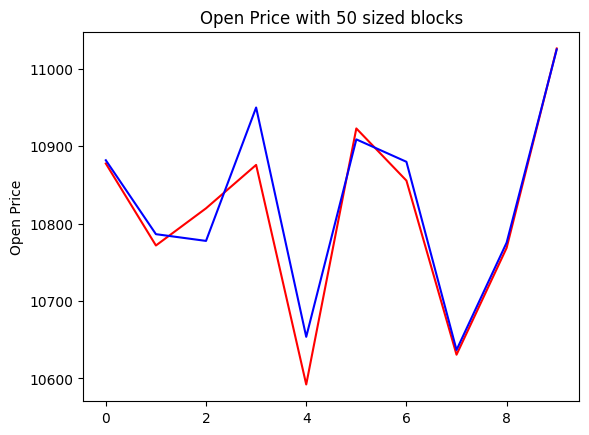

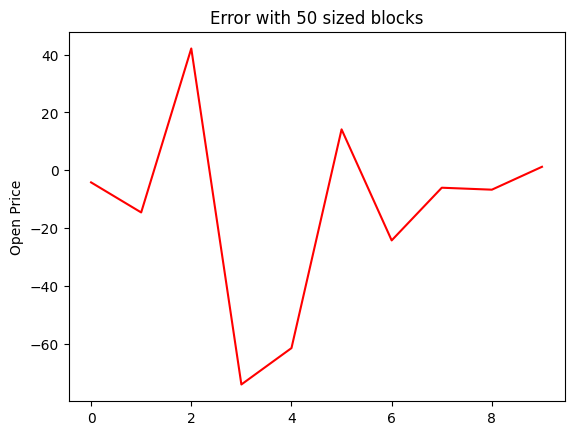

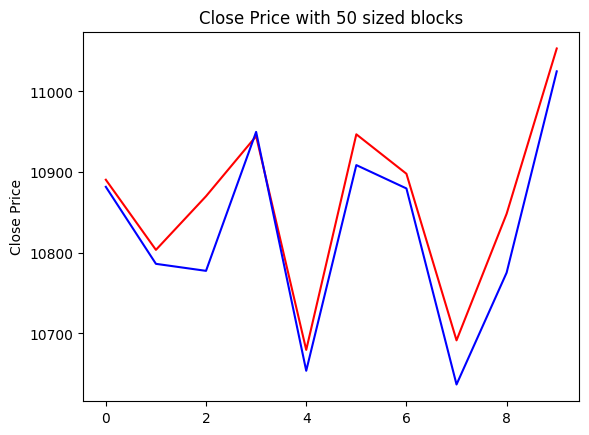

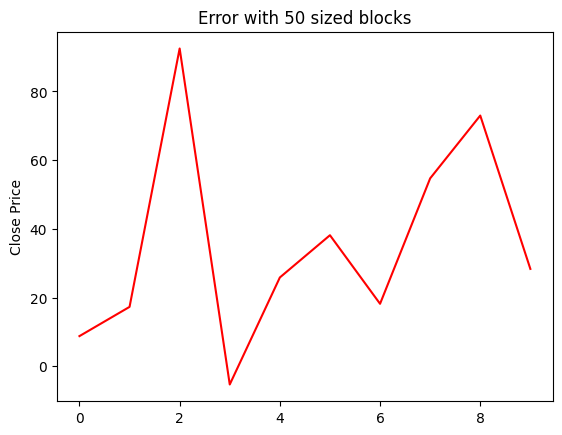

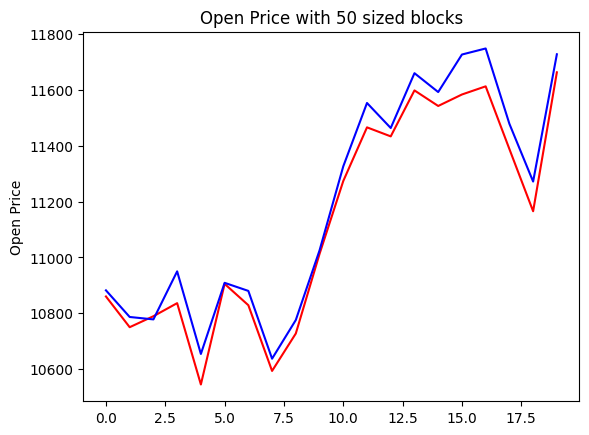

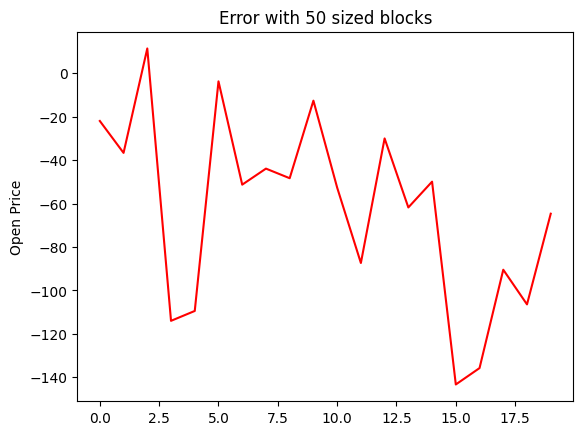

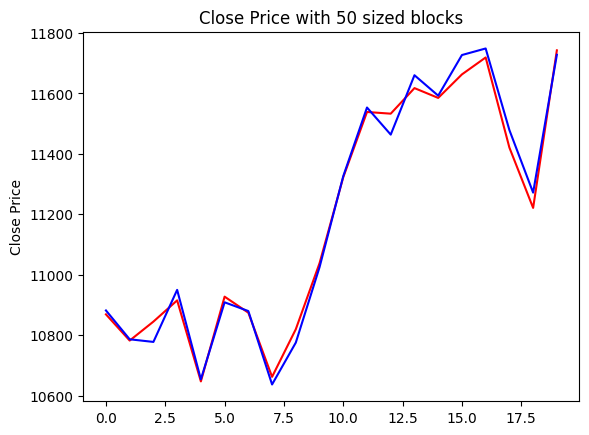

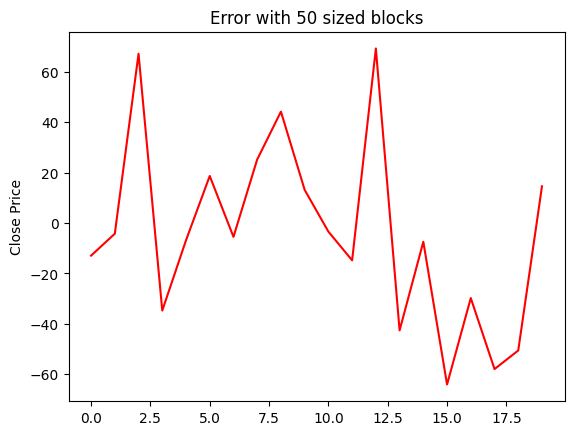

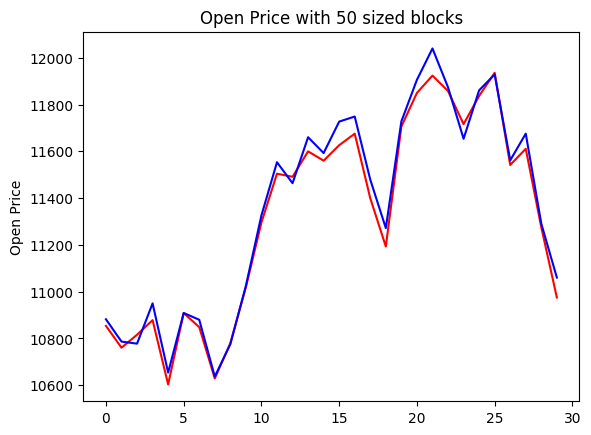

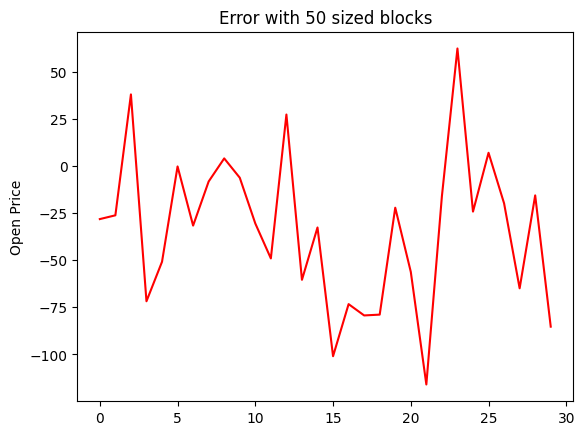

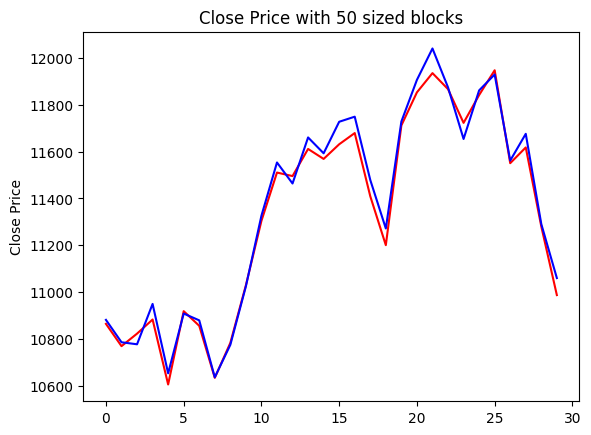

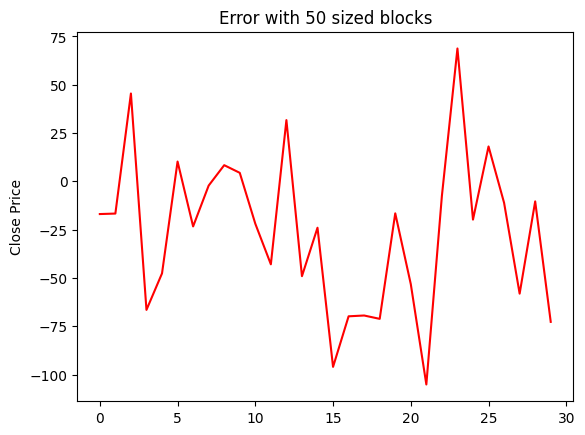

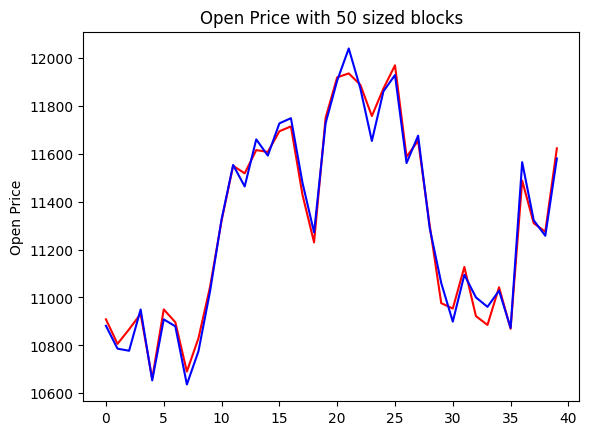

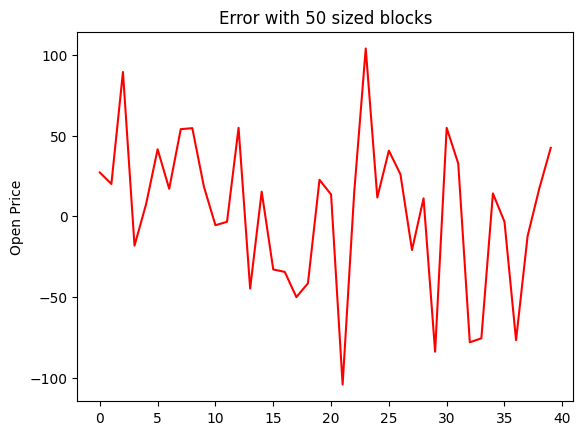

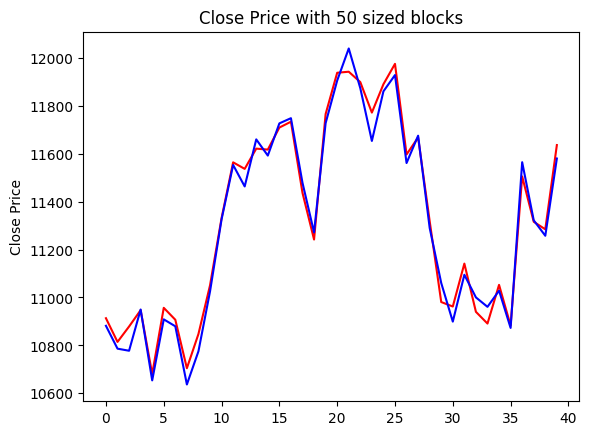

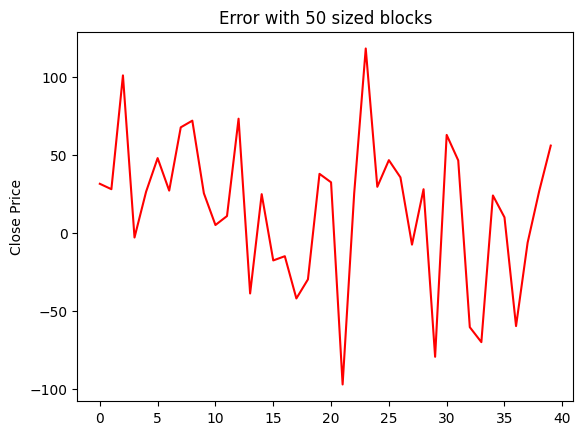

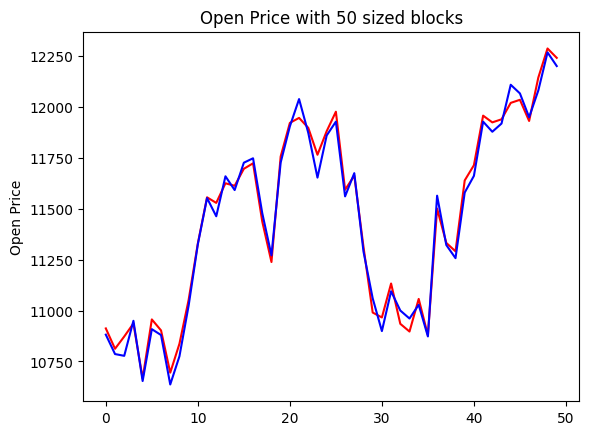

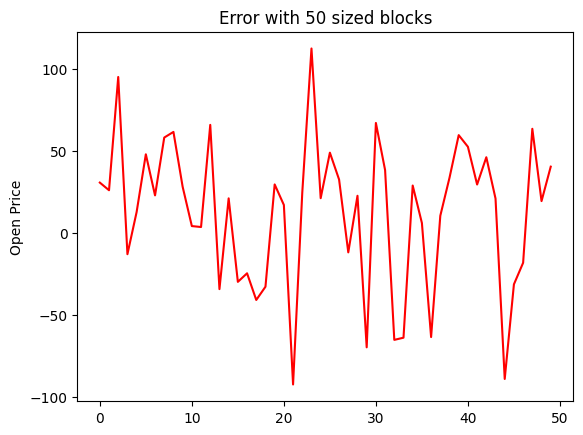

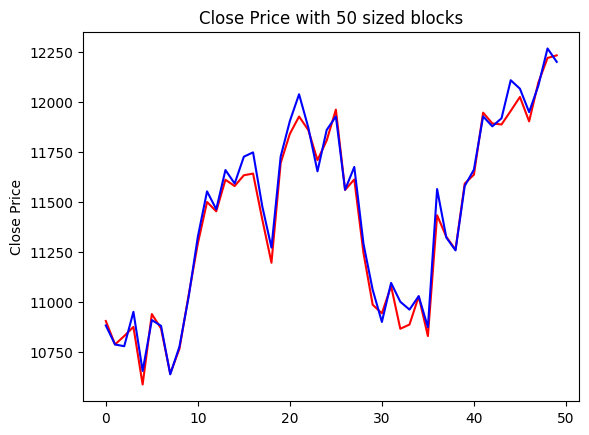

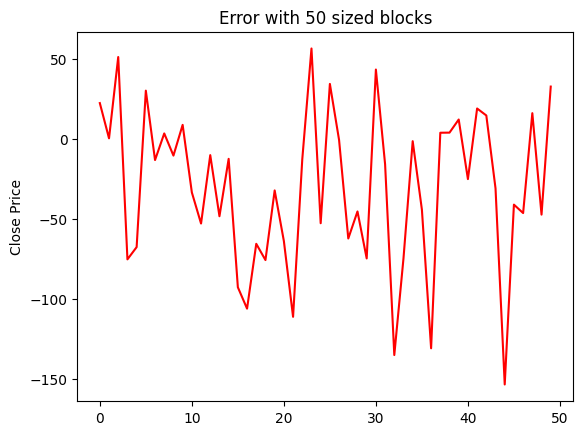

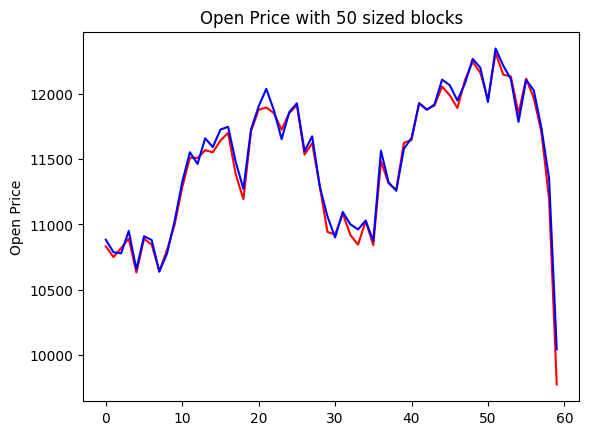

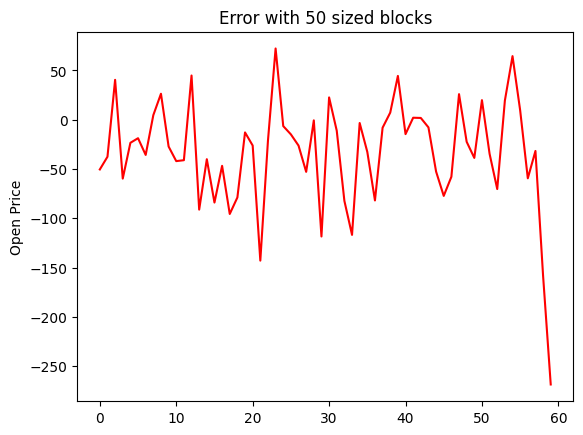

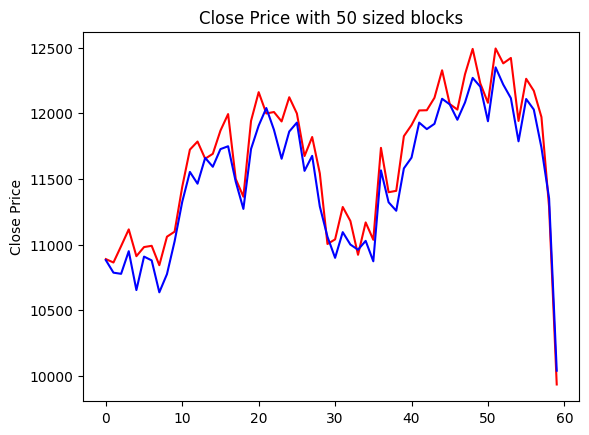

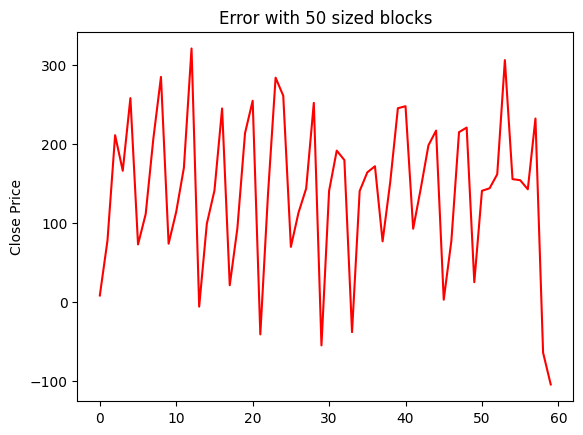

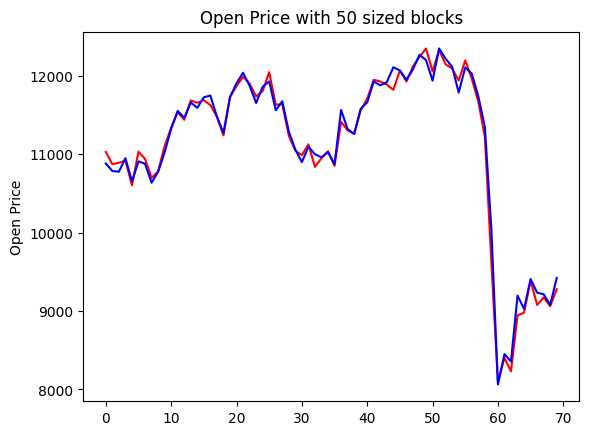

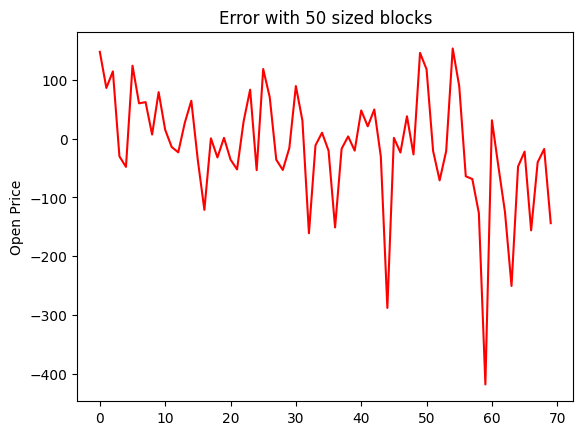

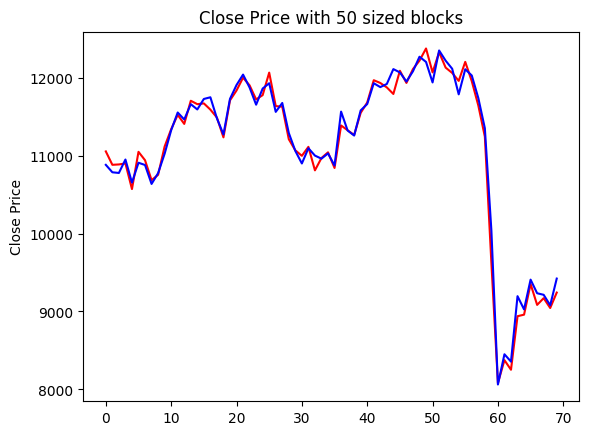

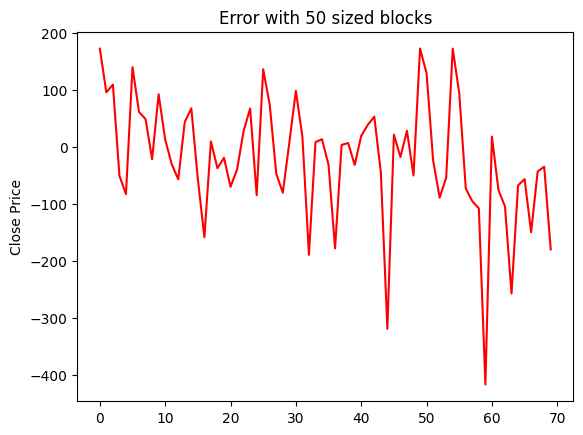

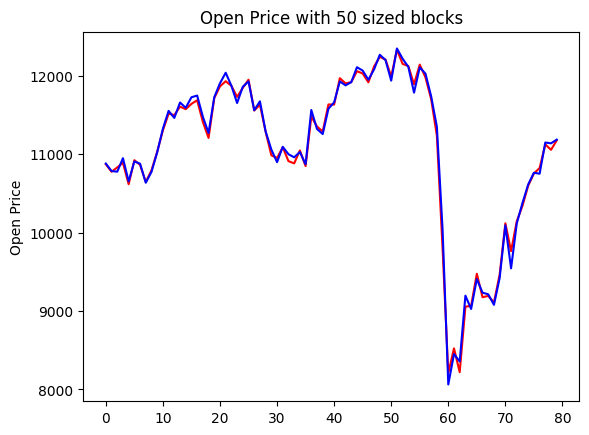

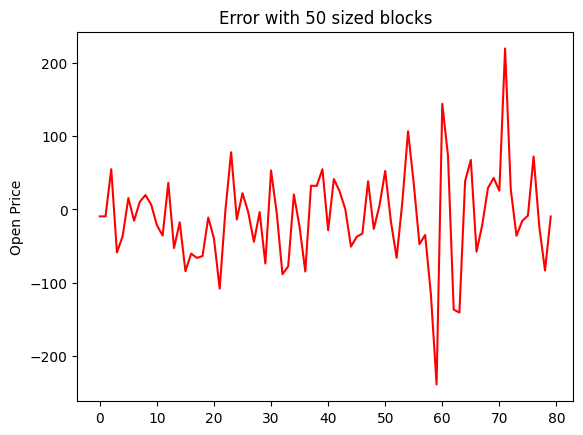

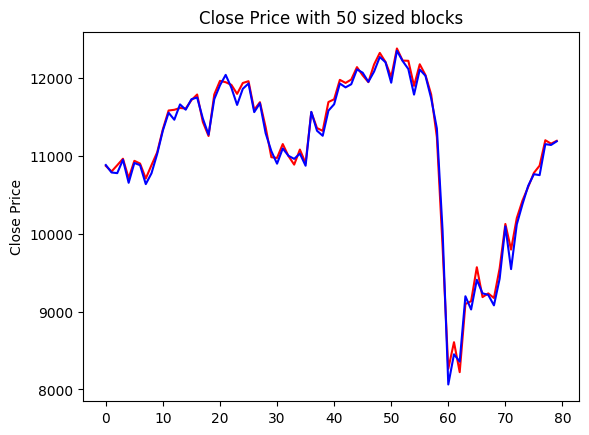

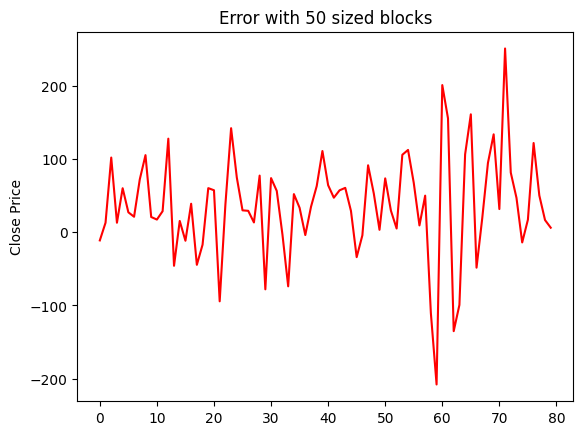

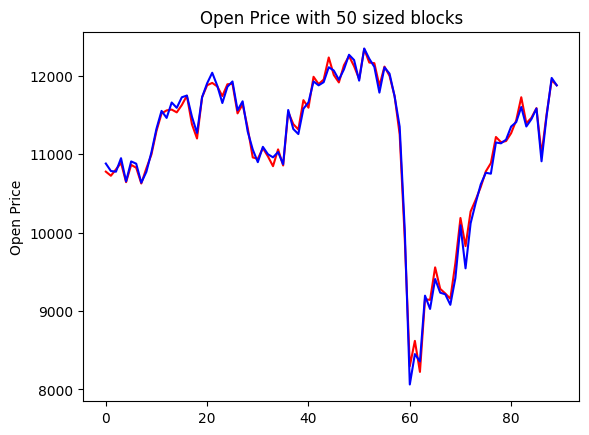

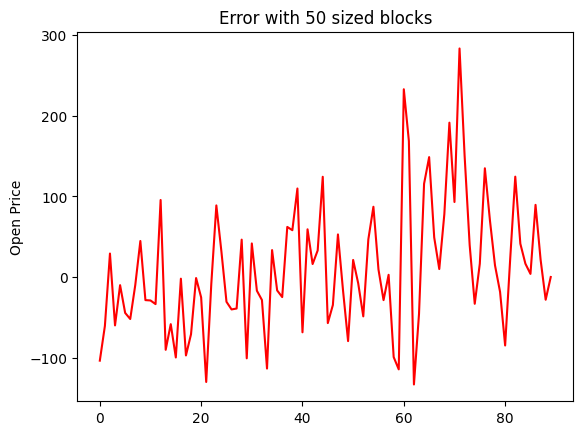

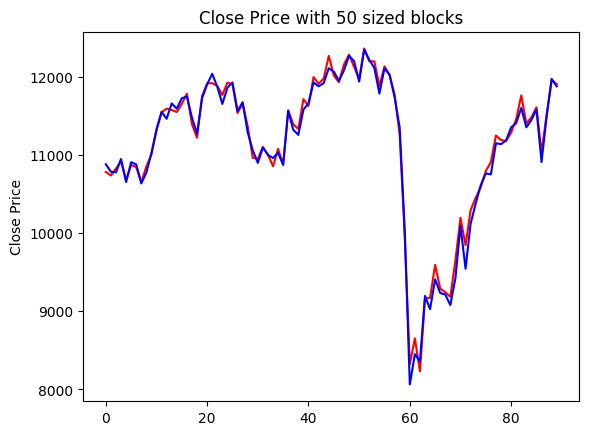

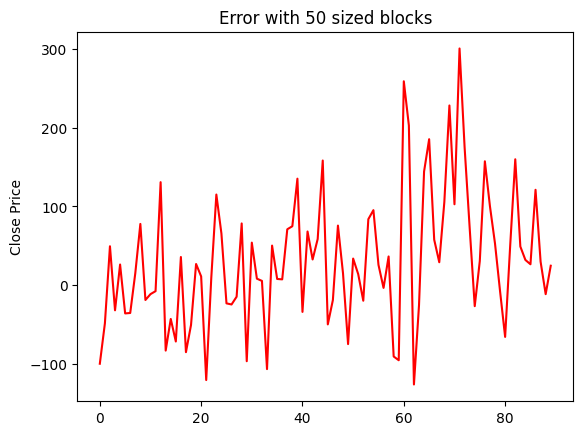

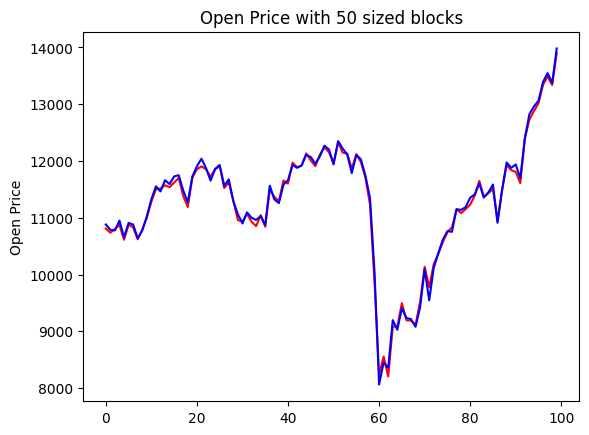

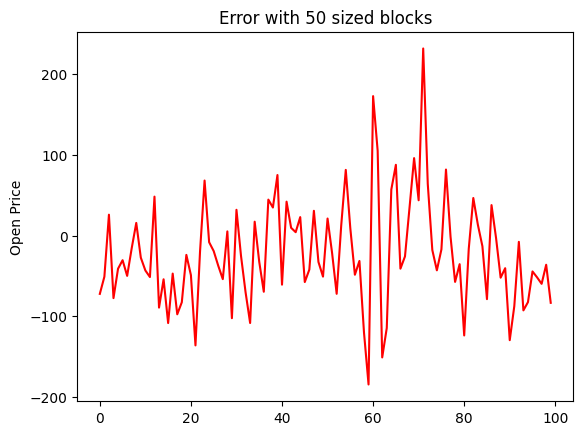

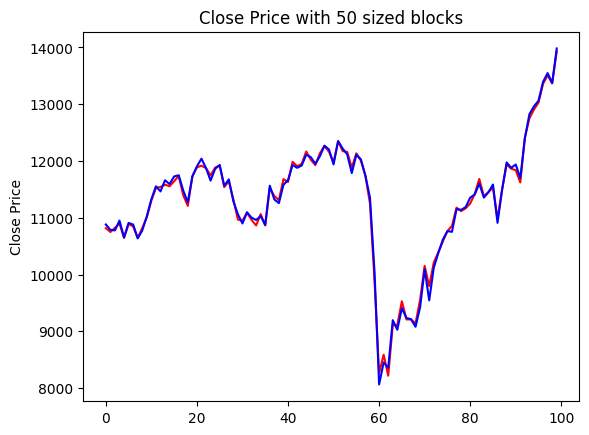

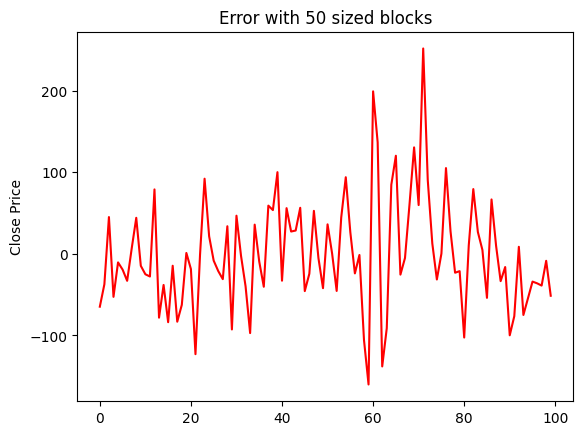

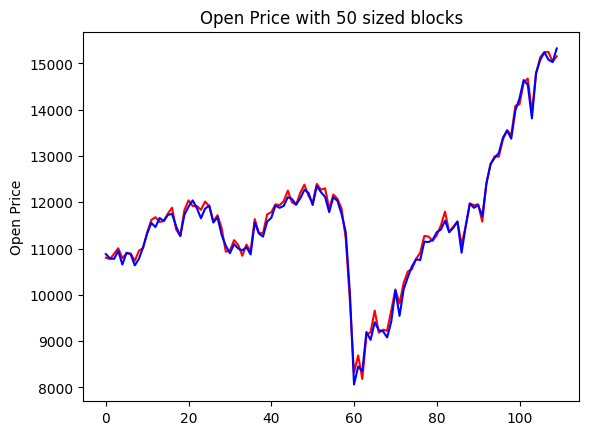

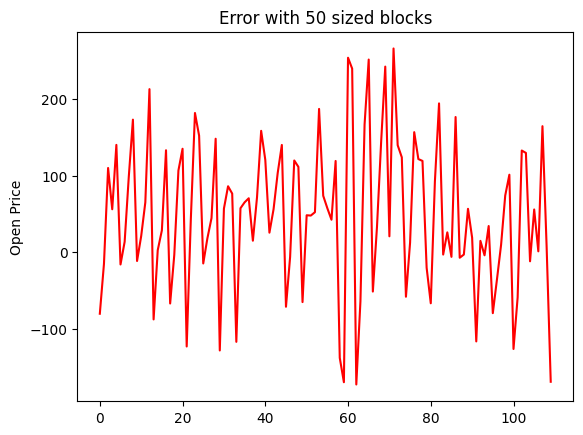

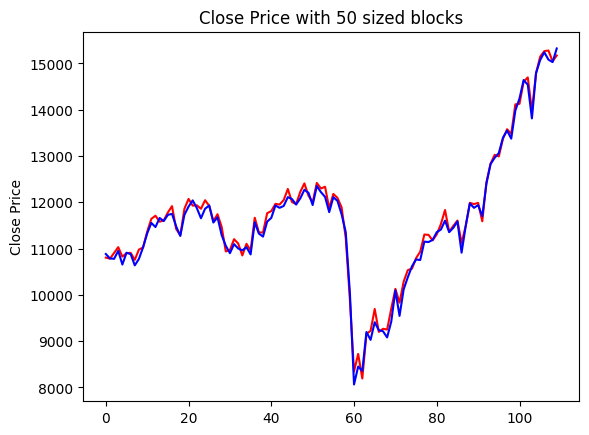

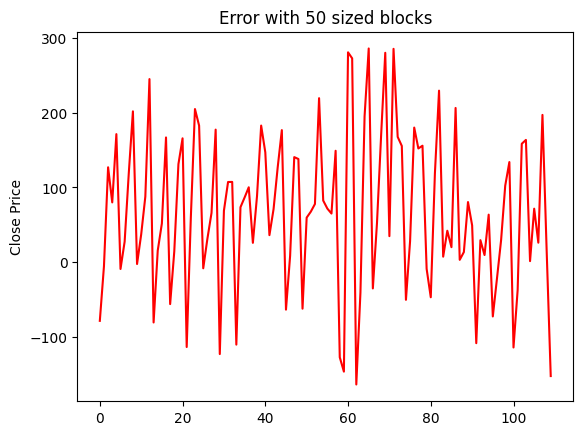

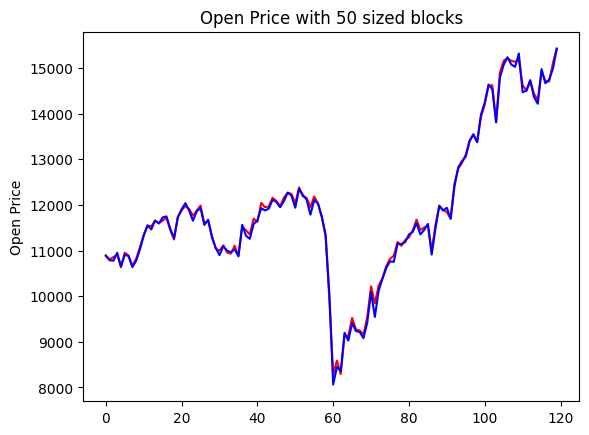

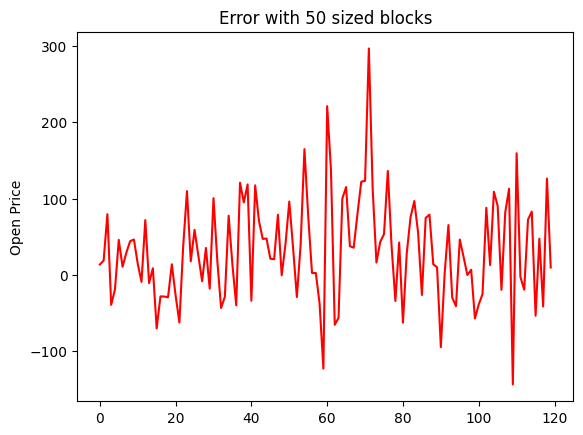

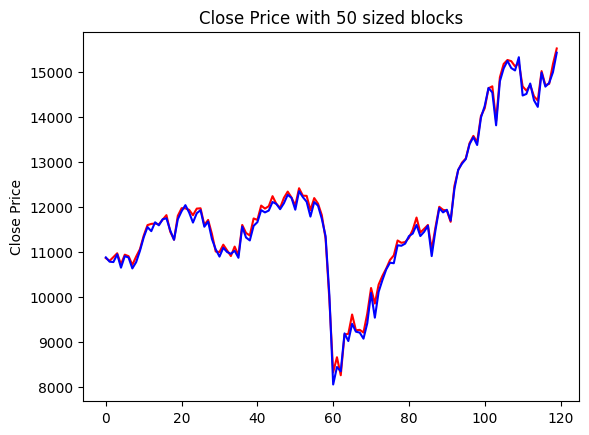

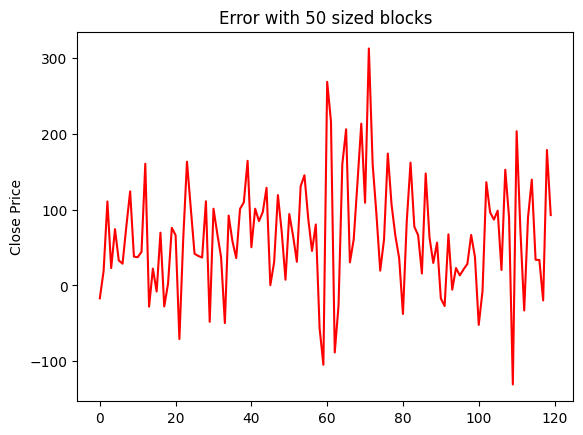

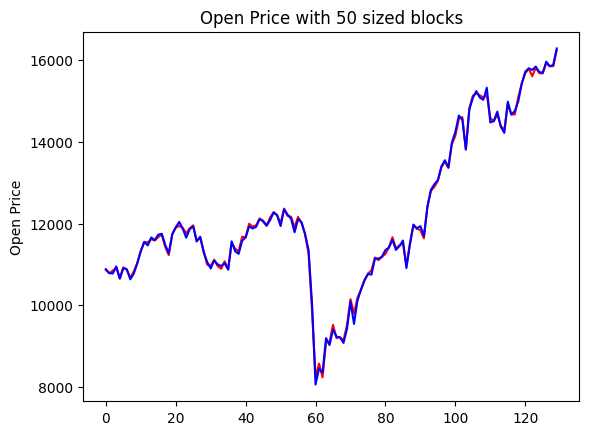

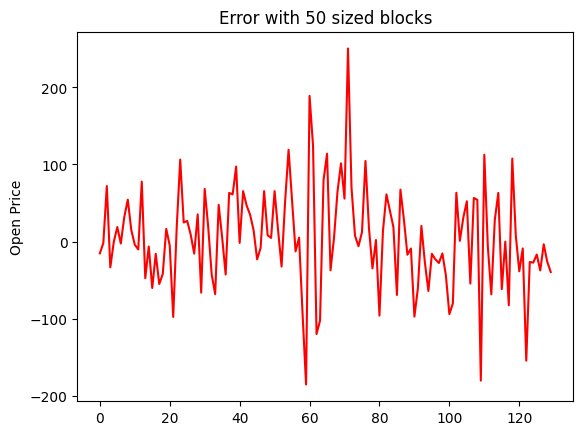

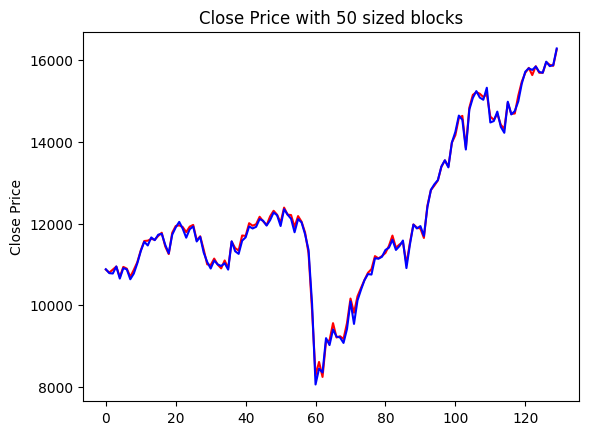

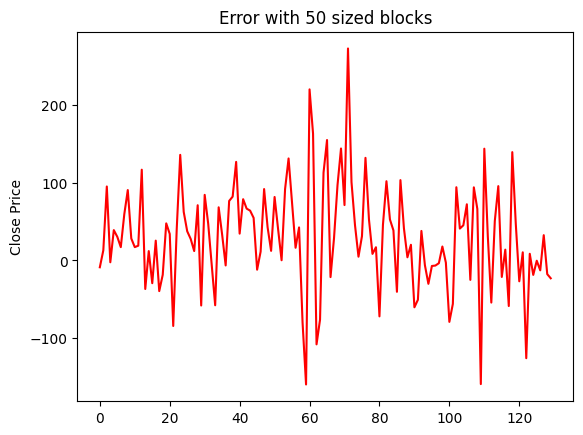

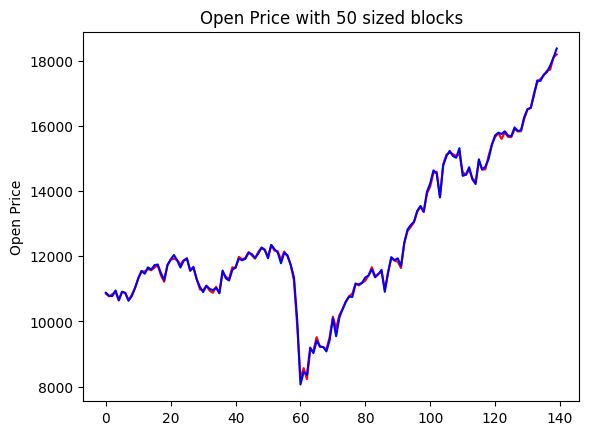

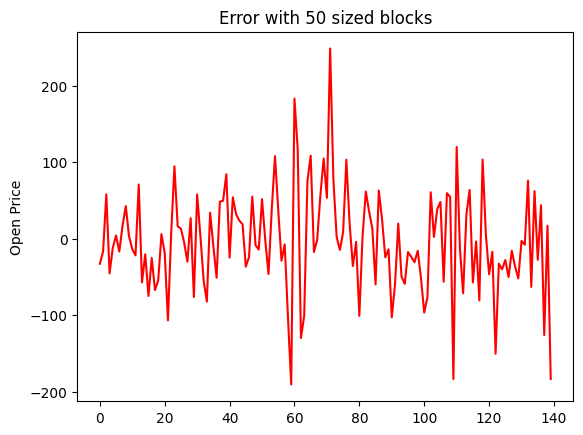

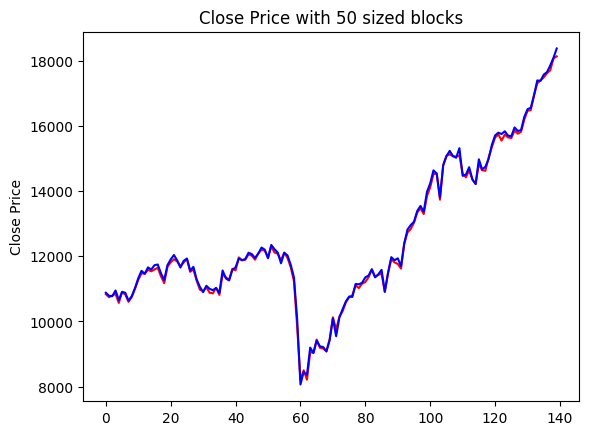

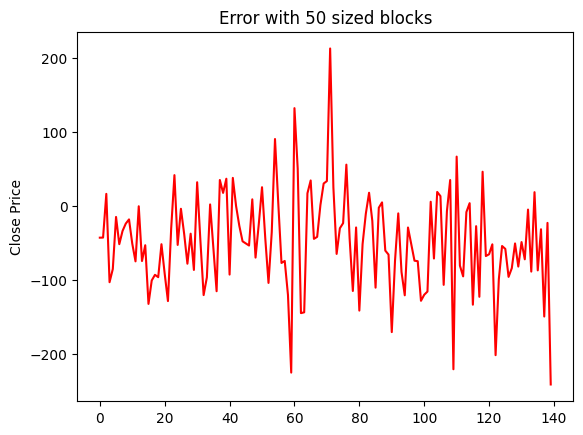

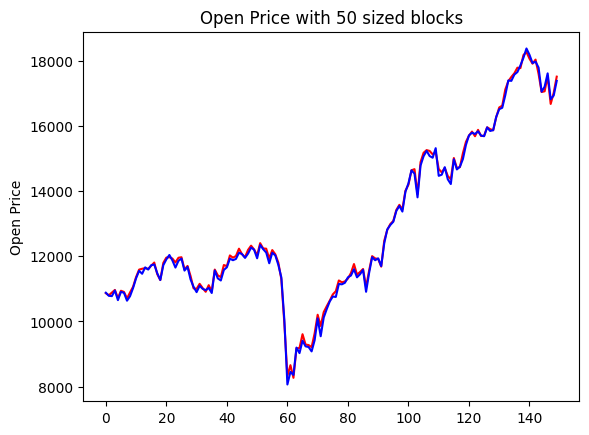

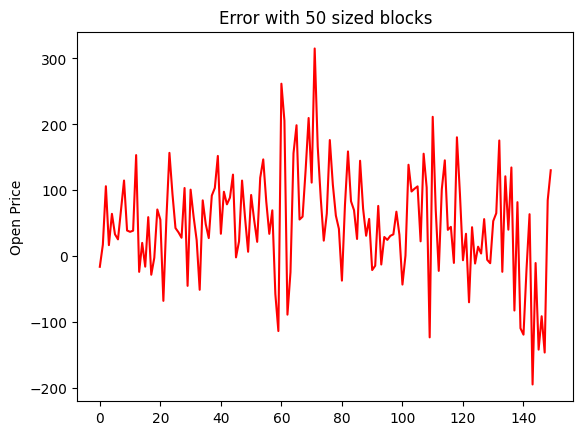

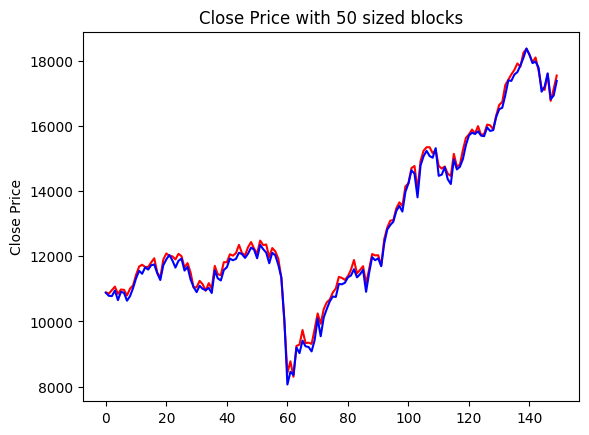

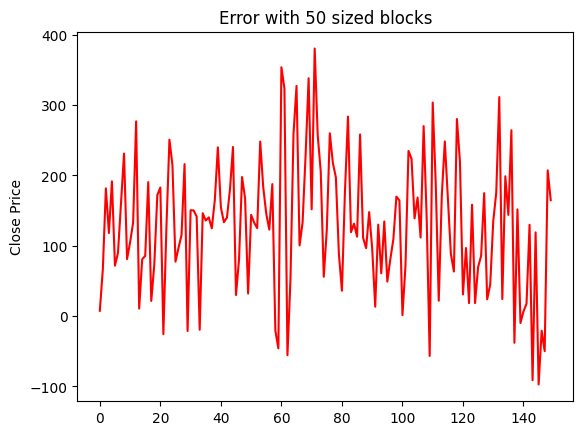

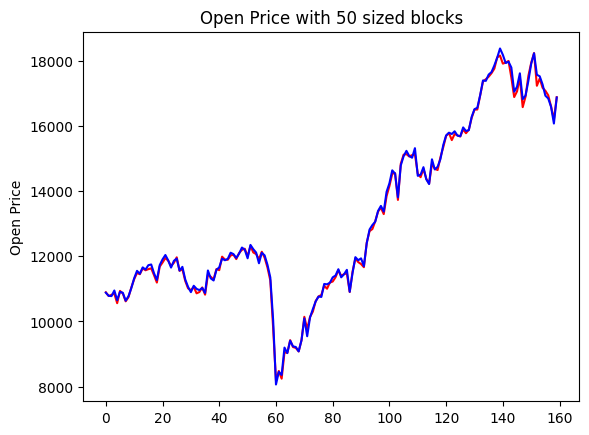

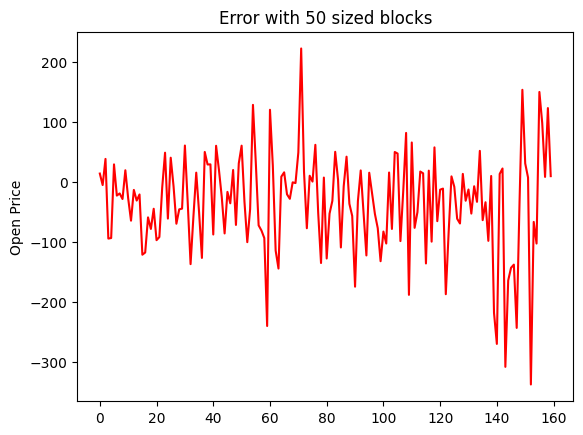

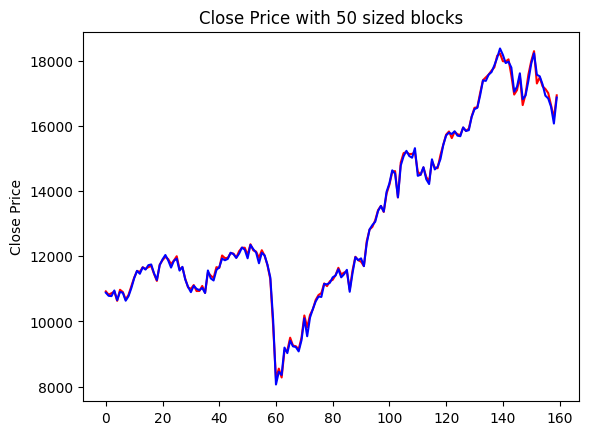

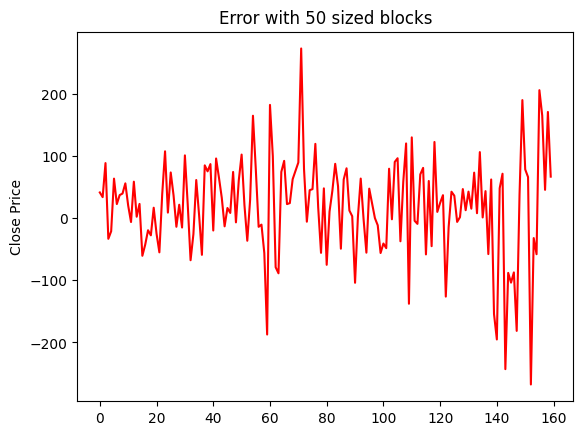

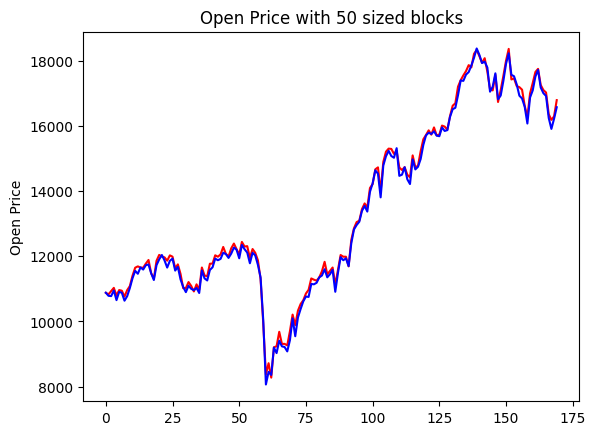

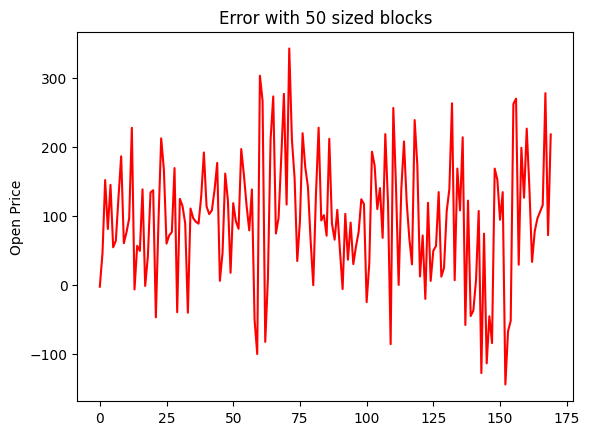

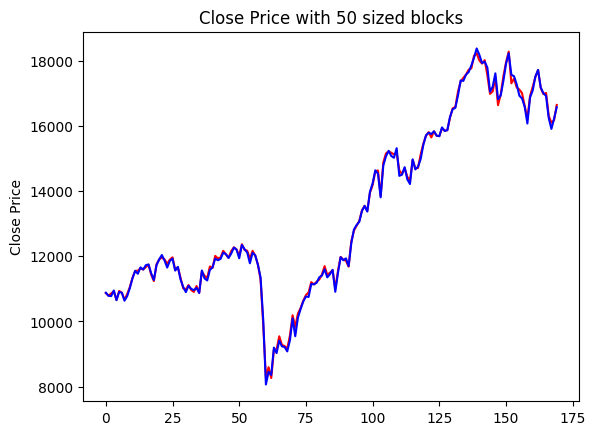

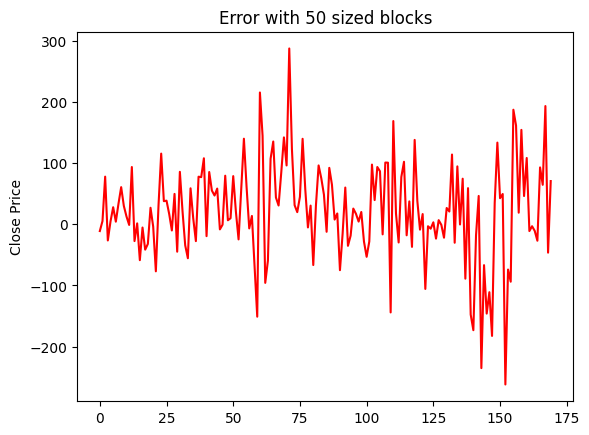

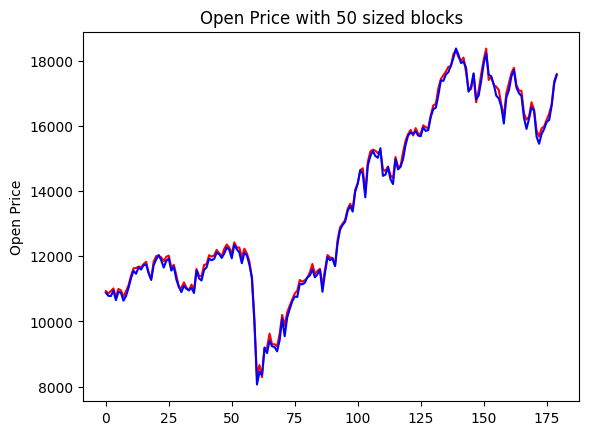

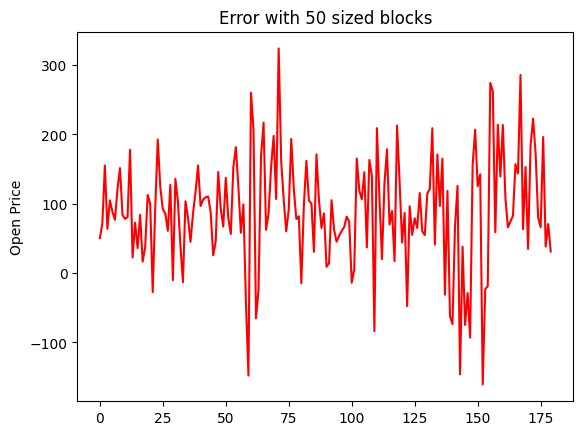

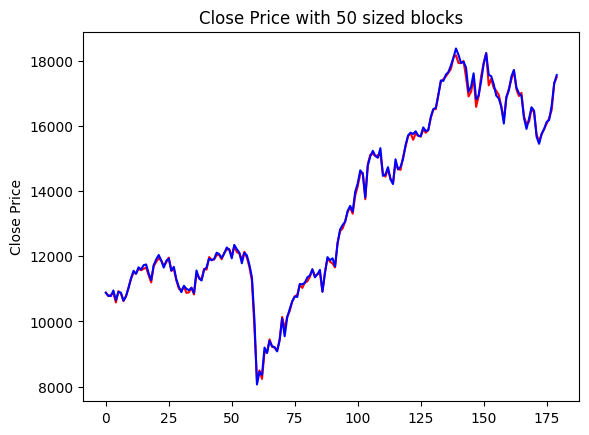

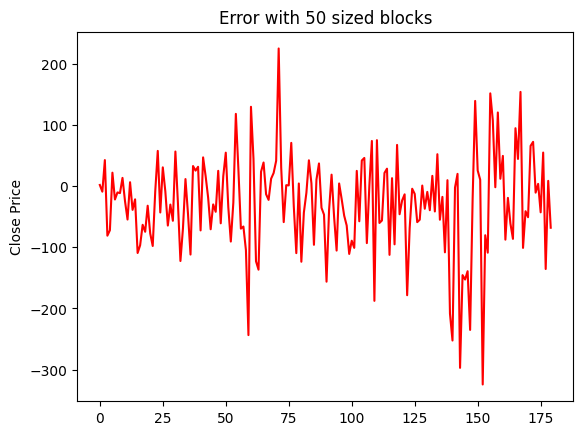

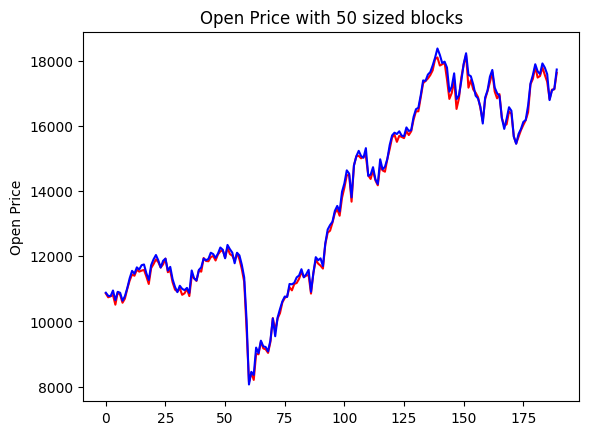

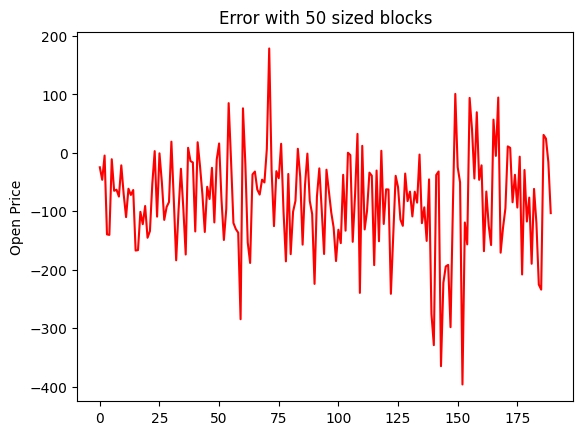

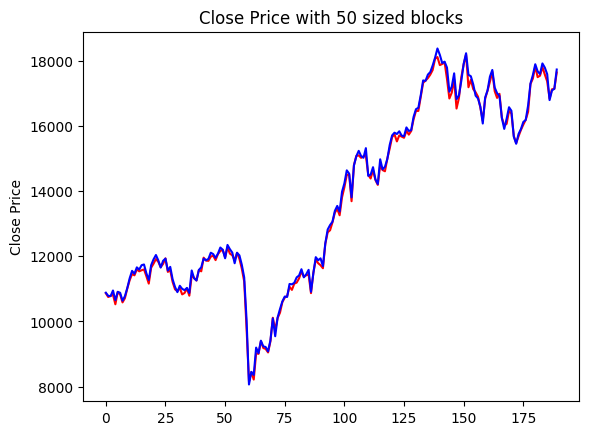

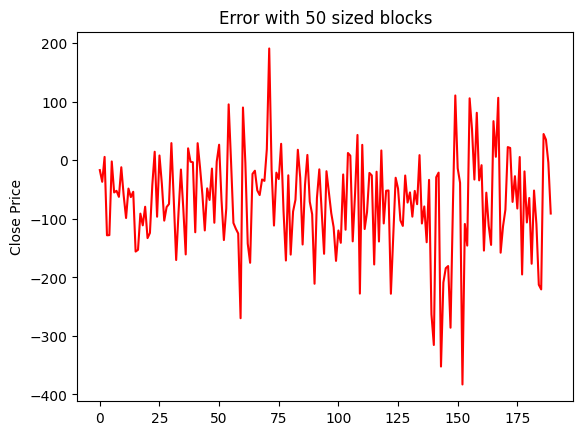

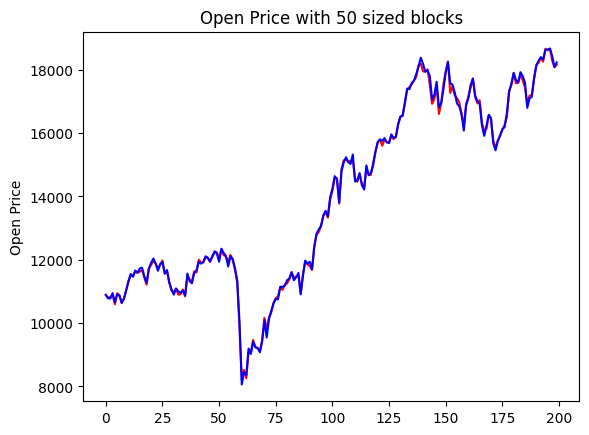

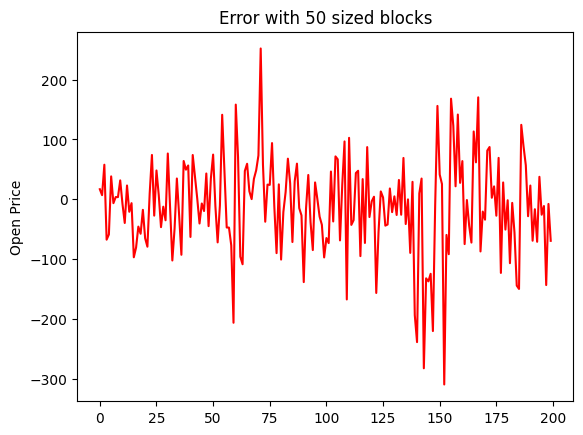

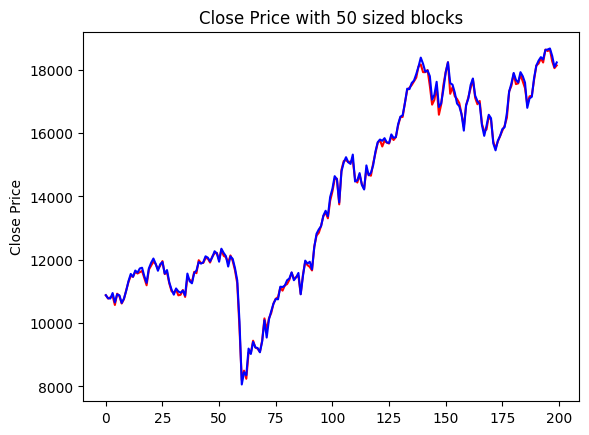

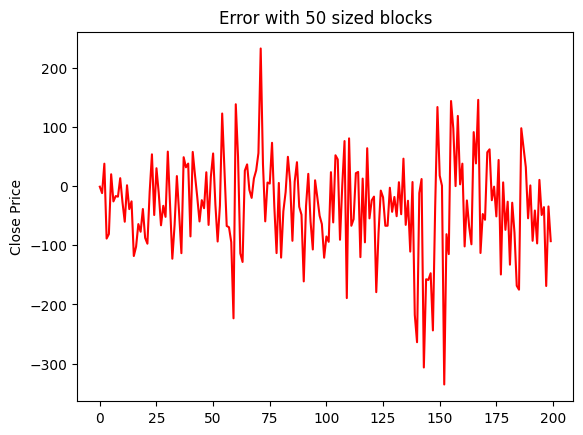

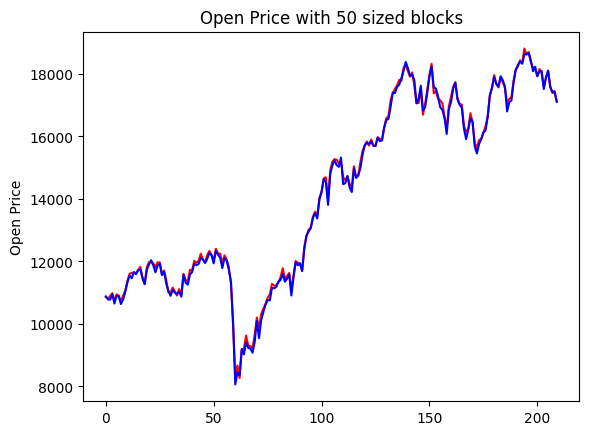

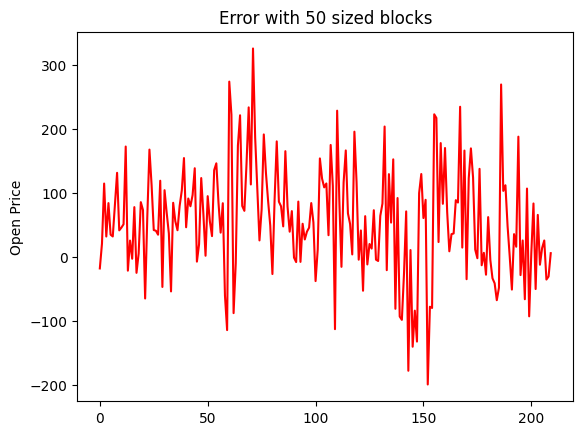

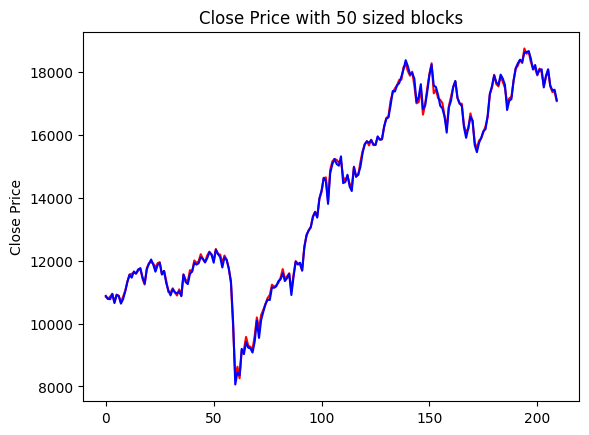

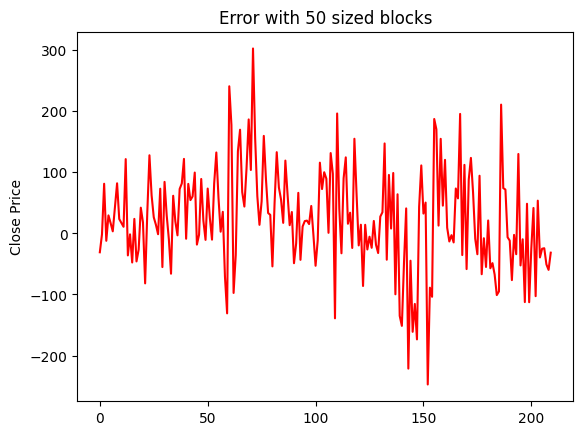

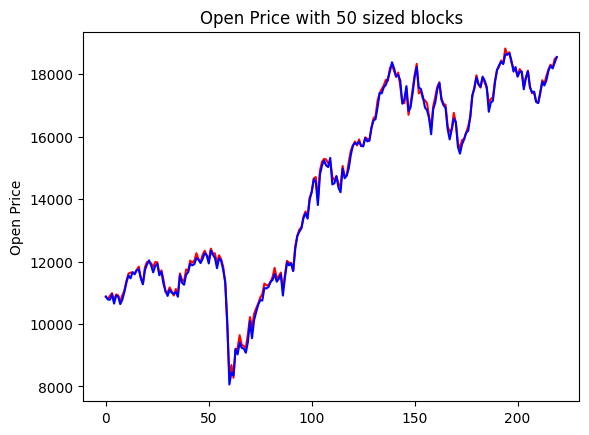

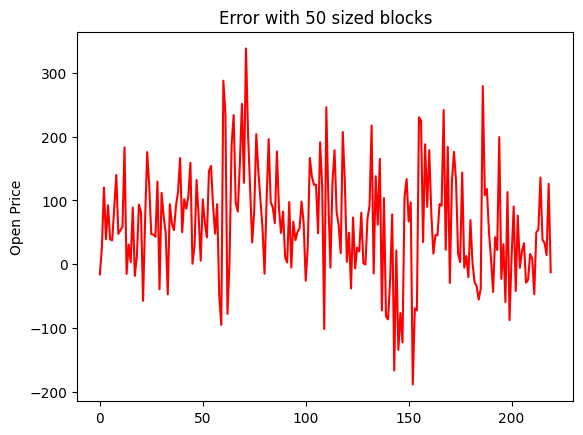

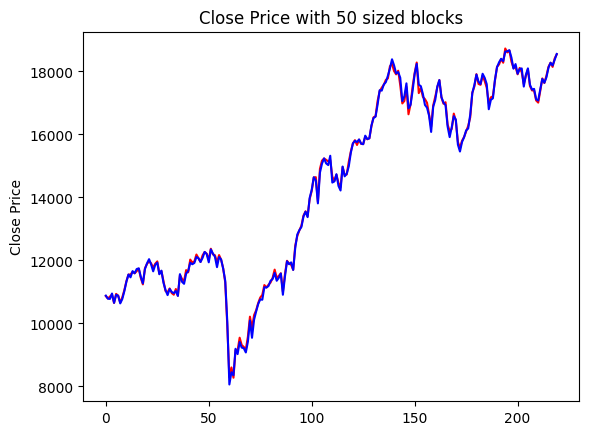

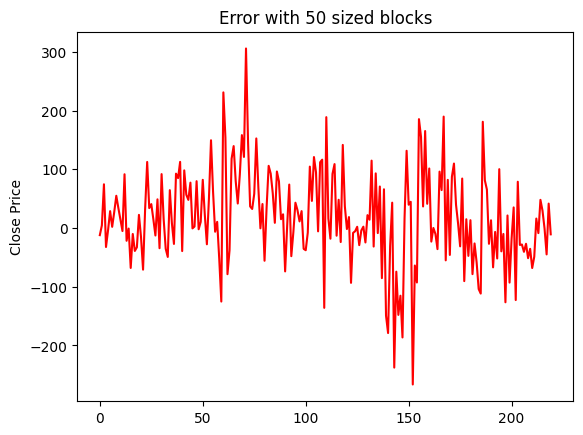

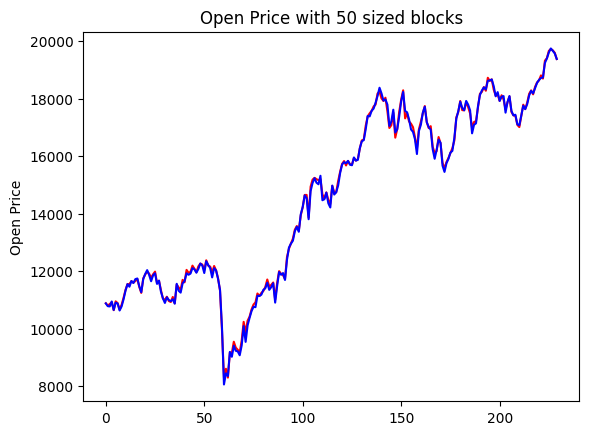

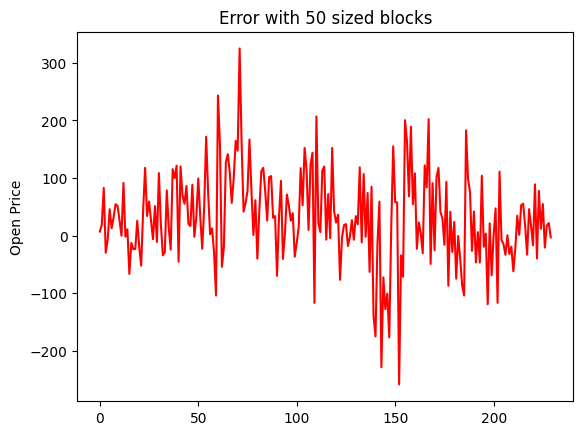

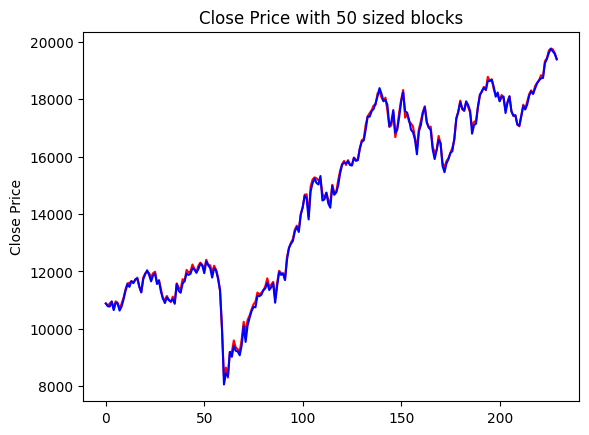

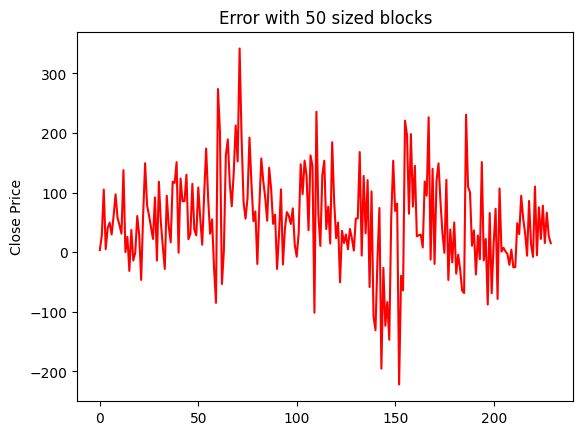

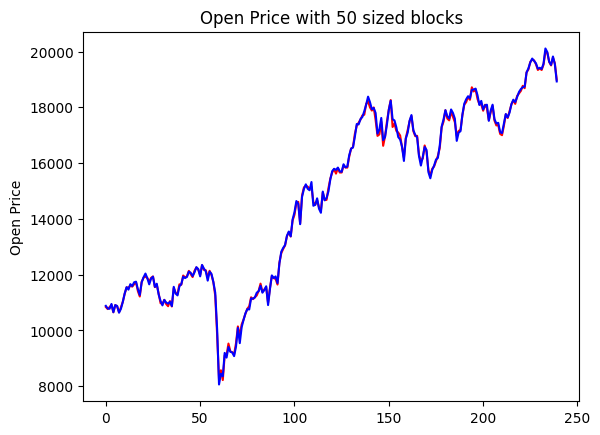

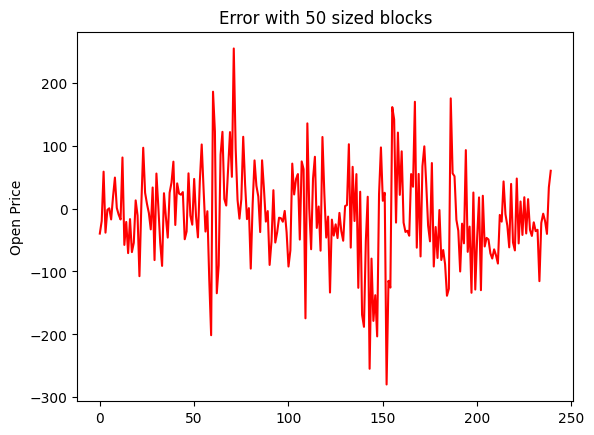

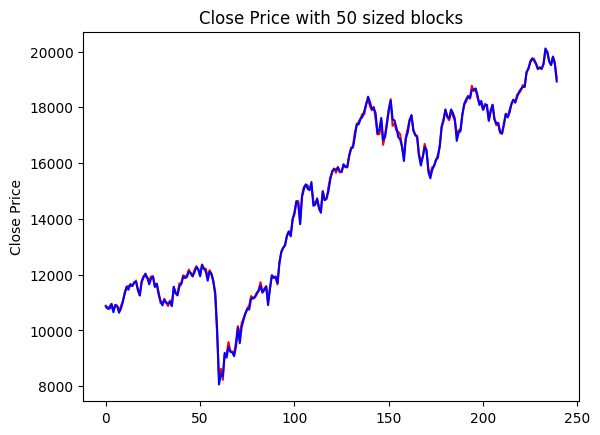

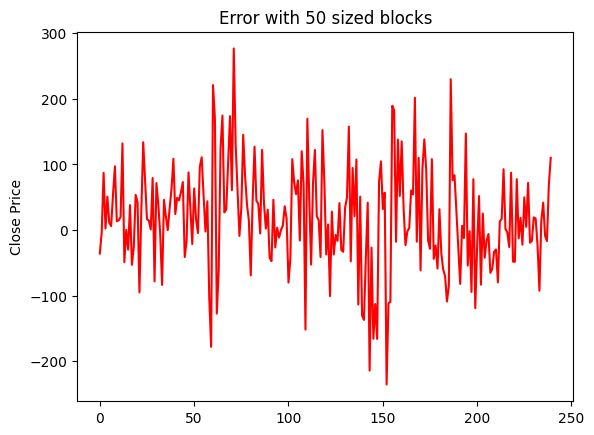

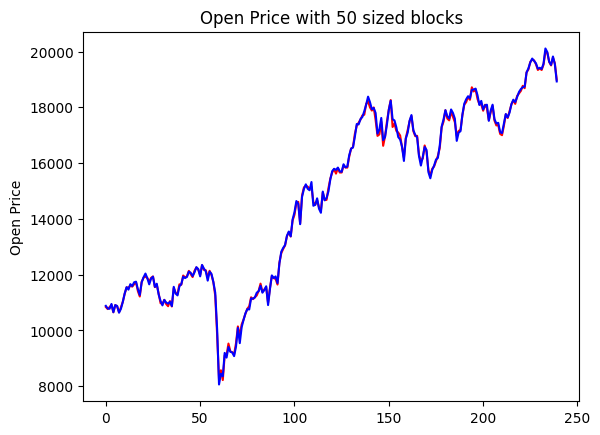

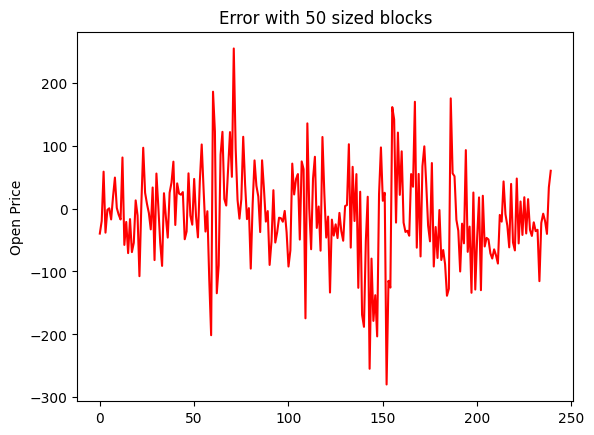

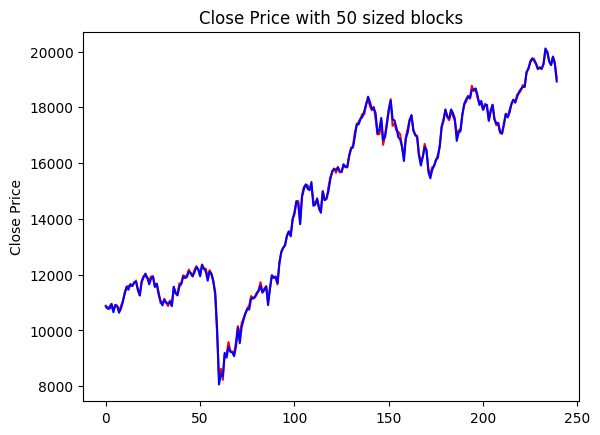

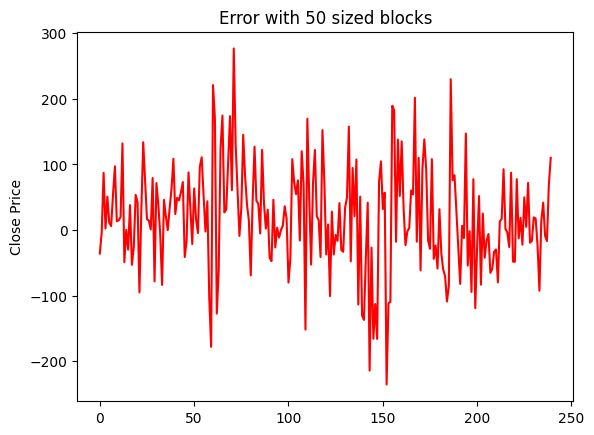

In [19]:
bmodel = block_SGD_model(50)
bmodel.block_gen(nifty_data)
bmodel.model_performance()